## 데이터셋 준비

In [23]:
import tensorflow as tf
from tensorflow import keras

import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

import copy
import cv2
from PIL import Image
import numpy as np

In [3]:
(ds_train, ds_test), ds_info = tfds.load('stanford_dogs',
                                         split=['train','test'], 
                                         shuffle_files=True, 
                                         with_info=True,
                                        )                              

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/12000 [00:00<?, ? examples/s]

Shuffling stanford_dogs-train.tfrecord...:   0%|          | 0/12000 [00:00<?, ? examples/s]

Generating test examples...:   0%|          | 0/8580 [00:00<?, ? examples/s]

Shuffling stanford_dogs-test.tfrecord...:   0%|          | 0/8580 [00:00<?, ? examples/s]

Dataset stanford_dogs downloaded and prepared to /aiffel/tensorflow_datasets/stanford_dogs/0.2.0. Subsequent calls will reuse this data.


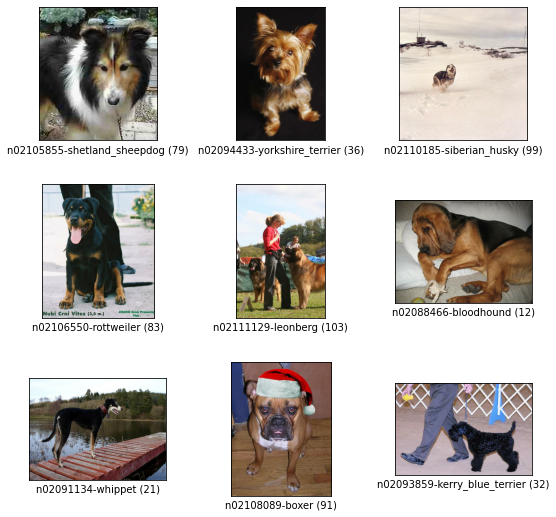

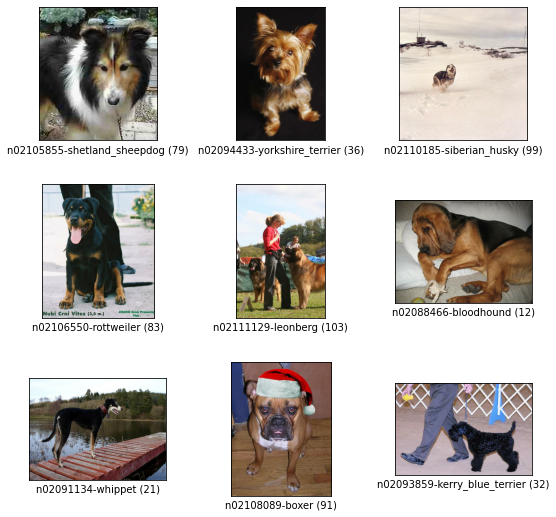

In [4]:
tfds.show_examples(ds_train, ds_info)

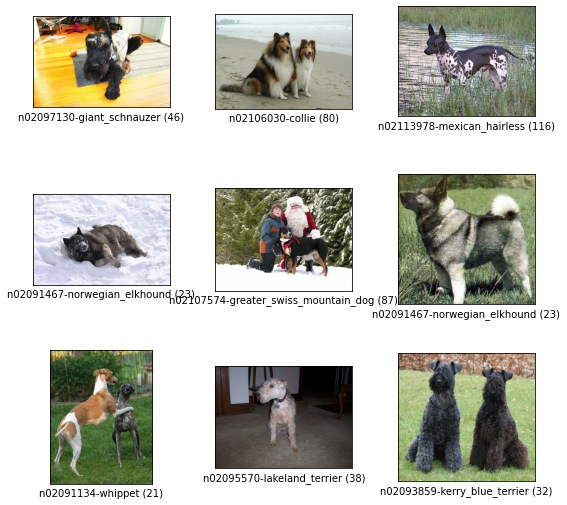

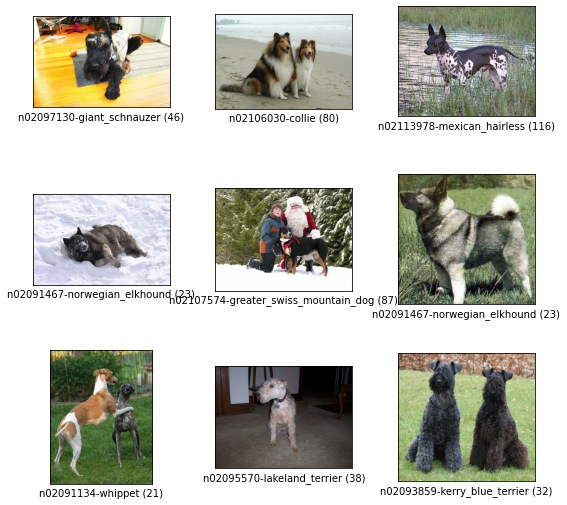

In [5]:
tfds.show_examples(ds_test, ds_info)

In [6]:
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'image/filename': Text(shape=(), dtype=tf.string),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=120),
    'objects': Sequence({
        'bbox': BBoxFeature(shape=(4,), dtype=tf.float32),
    }),
})

## CAM을 위한 모델 만들기

In [7]:
num_classes = ds_info.features["label"].num_classes
base_model = keras.applications.resnet50.ResNet50(
    include_top=False,  # Imagenet 분류기의 fully connected layer 제거
    weights='imagenet',
    input_shape=(224, 224, 3), 
    pooling='avg', # GAP 적용 
)
x=base_model.output
preds = keras.layers.Dense(num_classes, activation='softmax')(x)
cam_model = keras.Model(inputs=base_model.input, outputs=preds)

94781440/94765736 [==============================] - 0s 0us/step


In [8]:
cam_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

## CAM 모델 학습하기

In [9]:
def normalize_and_resize_img(input):
    image=tf.image.resize(input['image'],[224, 224])
    input['image']=tf.cast(image, tf.float32) / 255.
    return input['image'], input['label']

def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img,
        num_parallel_calls=2)
    ds = ds.batch(batch_size)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [10]:
# 데이터셋에 전처리와 배치처리를 적용함.
ds_train_norm = apply_normalize_on_dataset(ds_train)
ds_val_norm = apply_normalize_on_dataset(ds_test)

# 구성된 배치의 모양을 확인해 봄.
for input in ds_train_norm.take(1):
    image, label = input
    print(image.shape)
    print(label.shape)

(16, 224, 224, 3)
(16,)


In [11]:
cam_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
    metrics=['accuracy'],
)

In [12]:
history_cam_model = cam_model.fit(
    ds_train_norm,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=2,
    validation_data=ds_val_norm,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/2
750/750 [==============================] - 192s 202ms/step - loss: 2.2590 - accuracy: 0.4276 - val_loss: 3.2288 - val_accuracy: 0.2238
Epoch 2/2
750/750 [==============================] - 155s 207ms/step - loss: 0.6539 - accuracy: 0.8270 - val_loss: 1.2205 - val_accuracy: 0.6454


In [13]:
# 학습시킨 가중치 저장
import os
cam_model_path = os.getenv('HOME')+'/aiffel/class_activation_map/cam_model1.h5'
cam_model.save(cam_model_path)

/opt/conda/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


## CAM (Class Activation Map) 생성

In [15]:
def get_one(ds): 
    ds = ds.take(1) # 데이터셋에서 개별 이미지를 한장을 뽑음.
    sample_data = list(ds.as_numpy_iterator())
    bbox = sample_data[0]['objects']['bbox']
    image = sample_data[0]['image']
    label = sample_data[0]['label']
    return sample_data[0]

46


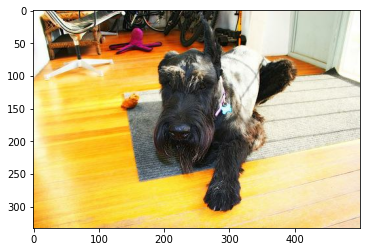

In [16]:
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])
plt.show()

In [17]:
# 미리 준비된 학습한 모델을 불러옴.
import os
cam_model_path = os.getenv('HOME') + '/aiffel/class_activation_map/cam_model.h5'
cam_model = tf.keras.models.load_model(cam_model_path)

In [26]:
# model과 item을 받았을 때 입력 이미지와 동일한 크기의 CAM을 반환하는 함수
def generate_cam(model, item):
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    
    img_tensor, class_idx = normalize_and_resize_img(item)
    
    # 학습한 모델에서 원하는 레이어의 output을 얻기 위해 모델의 input과 output을 새롭게 정의해줌.
    # model.layers[-3].output에서는 우리가 필요로 하는 GAP 이전 Convolution layer의 output을 얻을 수 있음.
    cam_model = tf.keras.models.Model([model.inputs], [model.layers[-3].output, model.output])
    conv_outputs, predictions = cam_model(tf.expand_dims(img_tensor, 0))
    conv_outputs = conv_outputs[0, :, :, :]
    
    # 모델의 weight activation은 마지막 레이어에 있음.
    class_weights = model.layers[-1].get_weights()[0]
    
    cam_image = np.zeros(dtype=np.float32, shape=conv_outputs.shape[0:2])
    for i, w in enumerate(class_weights[:, class_idx]):
        # conv_outpus의 i번째 채널과 i번째 weight를 곱해서 누적하면 활성화된 정도가 나타남.
        cam_image += w * conv_outputs[:, :, i]
        
    cam_image /= np.max(cam_image) # activation score를 normalize함.
    cam_image = cam_image.numpy()
    cam_image = cv2.resize(cam_image, (width, height)) # 원래 이미지의 크기로 resize함.
    return cam_image

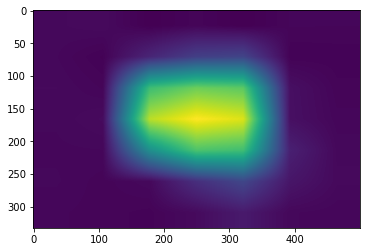

In [28]:
# CAM을 얻음.
cam_image = generate_cam(cam_model, item)
plt.imshow(cam_image)
plt.show()

In [30]:
#  CAM 이미지를 원본 이미지와 합쳐봄.
def visualize_cam_on_image( src1, src2, alpha=0.5 ):
    beta = (1.0 - alpha)
    merged_image = cv2.addWeighted( src1, alpha, src2, beta, 0.0 )
    return merged_image

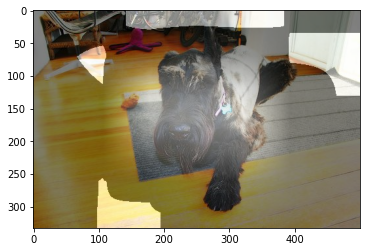

In [31]:
origin_image = item['image'].astype(np.uint8)
cam_image_3channel = np.stack([cam_image*255]*3, axis=-1).astype(np.uint8)

blended_image = visualize_cam_on_image(cam_image_3channel, origin_image)
plt.imshow(blended_image)
plt.show()

## Grad-CAM

116


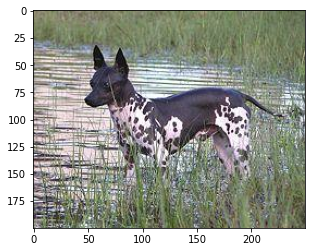

In [33]:
# 새로운 이미지를 뽑음.
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])
plt.show()

In [35]:
# generate_grad_cam()에서는 원하는 레이어의 output과 특정 클래스의 prediction 사이의 그래디언트 grad_val을 얻고 이를 weights로 활용
def generate_grad_cam(model, activation_layer, item):
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    img_tensor, class_idx = normalize_and_resize_img(item)
    
    # 해당 레이어의 이름을 찾은 후, output으로 추가함.
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(activation_layer).output, model.output])
    
    # Gradient를 얻기 위해 tape를 사용함.
    with tf.GradientTape() as tape:
        conv_output, pred = grad_model(tf.expand_dims(img_tensor,0))
        
        loss = pred[:, class_idx] # 원하는 class 예측값을 얻음.
        output = conv_output[0] # 원하는 레이어의 output을 얻음.
        grad_val = tape.gradient(loss, conv_output)[0] # 예측값에 따른 레이어의 gradient를 얻음.
        
    weights = np.mean(grad_val, axis=(0,1)) # gradient의 GAP로 weight를 구함.
    grad_cam_image = np.zeros(dtype=np.float32, shape=conv_output.shape[0:2])
    for k, w in enumerate(weights):
        grad_cam_image += w * output[:, :, k]
        
    grad_cam_image = tf.math.maximum(0, grad_cam_image)
    grad_cam_image /= np.max(grad_cam_image)
    grad_cam_image = grad_cam_image.numpy()
    grad_cam_image = cv2.resize(grad_cam_image, (width, height))
    return grad_cam_image

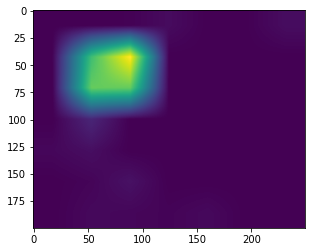

In [36]:
grad_cam_image = generate_grad_cam(cam_model, 'conv5_block3_out', item)
plt.imshow(grad_cam_image)
plt.show()

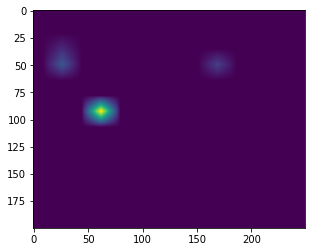

In [37]:
grad_cam_image = generate_grad_cam(cam_model, 'conv4_block3_out', item)
plt.imshow(grad_cam_image)
plt.show()

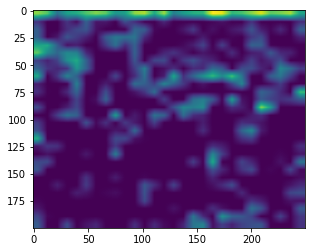

In [38]:
grad_cam_image = generate_grad_cam(cam_model, 'conv3_block3_out', item)
plt.imshow(grad_cam_image)
plt.show()

## Detection with CAM

67


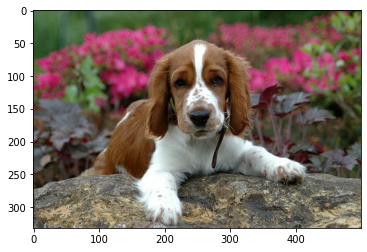

In [39]:
# 새로운 이미지를 뽑음.
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])
plt.show()

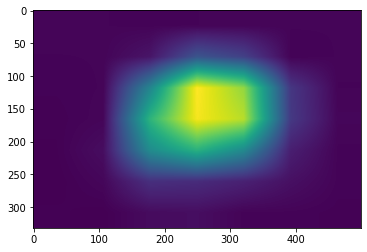

In [40]:
cam_image = generate_cam(cam_model, item)
plt.imshow(cam_image)
plt.show()

In [41]:
def get_bbox(cam_image, score_thresh=0.05):  # score_thresh를 받아 역치값 이하의 바운딩 박스는 없앰.
    low_indicies = cam_image <= score_thresh
    cam_image[low_indicies] = 0
    cam_image = (cam_image*255).astype(np.uint8)
    
    # OpenCV의 findContours()와 minAreaRect()로 사각형을 찾음.
    contours,_ = cv2.findContours(cam_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cnt = contours[0]
    rotated_rect = cv2.minAreaRect(cnt)
    rect = cv2.boxPoints(rotated_rect)
    rect = np.int0(rect)
    return rect

In [43]:
rect = get_bbox(cam_image)
rect

array([[111,  33],
       [443,  33],
       [443, 294],
       [111, 294]])

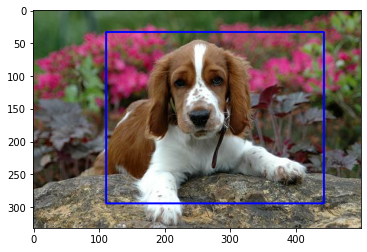

In [44]:
image = copy.deepcopy(item['image'])
image = cv2.drawContours(image, [rect], 0, (0,0,255), 2)
plt.imshow(image)
plt.show()

In [45]:
# rect의 좌표는 (x,y) 형태로, bbox는 (y_min, x_min, y_max, x_max)의 normalized 형태로 주어짐.
def rect_to_minmax(rect, image):
    bbox = [
        rect[:,1].min()/float(image.shape[0]),
        rect[:,0].min()/float(image.shape[1]),
        rect[:,1].max()/float(image.shape[0]),
        rect[:,0].max()/float(image.shape[1])
    ]
    return bbox

In [46]:
# rect를 bbox형태로 치환함.
pred_bbox = rect_to_minmax(rect, item['image'])
pred_bbox

[0.09939759036144578, 0.222, 0.8855421686746988, 0.886]

In [47]:
item['objects']['bbox']

array([[0.13554217, 0.146     , 0.9879518 , 0.826     ]], dtype=float32)

In [50]:
# CAM 추론 결과로 얻어진 bbox가 ground truth bbox와 비슷하게 얻어졌는지 IoU 계산
def get_iou(boxA, boxB):
    y_min = max(boxA[0], boxB[0])
    x_min = max(boxA[1], boxB[1])
    y_max = min(boxA[2], boxB[2])
    x_max = min(boxA[3], boxB[3])
    
    interArea = max(0, x_max - x_min) * max(0, y_max - y_min)
    boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    iou = interArea / float(boxAArea + boxBArea - interArea)
    
    return iou

In [51]:
get_iou(pred_bbox, item['objects']['bbox'][0])

0.6983858334151163